In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
import janitor as jn
import yellowbrick.features as ybf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

In [3]:
df = pd.read_csv('../data/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def tweak_titanic(df):
    df = (
        df.drop(columns=["Name", "Ticket", "Cabin"])
            .pipe(pd.get_dummies, drop_first=True)
    )
    return df

def get_train_test_X_y(df, target, size=0.3, std_cols=None):
    X, y = df.get_features_targets(target_columns=target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    
    imp = IterativeImputer()
    fitted = imp.fit_transform(X_train[num_cols])
    
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = imp.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    
    if std_cols:
        std = StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "Pclass,Age,SibSp,Fare".split(",")

target = "Survived"

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, target, std_cols=std_cols)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8171641791044776

In [24]:
dt.predict(X.iloc[[0]])
dt.predict_proba(X.iloc[[0]])
dt.predict_log_proba(X.iloc[[0]])

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\tree\_classes.py:965: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[-inf,   0.]])

In [41]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

dot_data='tree.dot'

export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["Died", "Survived"],
    filled=True,
)

graph, = pydot.graph_from_dot_file(dot_data)
graph.write_png('tree.png')

In [42]:
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

Sex_male       0.589
Pclass         0.181
Fare           0.095
SibSp          0.070
Age            0.064


In [50]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)
rf.predict(X.iloc[[0]])
rf.predict_proba(X.iloc[[0]])
rf.predict_log_proba(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:635: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[  0., -inf]])

In [32]:
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.280
fare           0.274
sex_male       0.230
pclass         0.086
sibsp          0.053


In [51]:
import rfpimp

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(rf, X_test, y_test).Importance

Feature
Sex_male       0.164179
Pclass         0.048507
PassengerId    0.014925
Age            0.011194
Fare           0.011194
SibSp          0.007463
Parch          0.003731
Embarked_Q     0.000000
Embarked_S     0.000000
Name: Importance, dtype: float64

## Gradient Boosted

In [52]:
import lightgbm as lgb

lgbm_class = lgb.LGBMClassifier(random_state=42)
lgbm_class.fit(X_train, y_train)
lgbm_class.score(X_test, y_test)

0.8097014925373134

In [53]:
lgbm_class.predict(X.iloc[[0]])
lgbm_class.predict_proba(X.iloc[[0]])

array([[0.04500859, 0.95499141]])

In [55]:
for col, val in sorted(
    zip(X.columns, lgbm_class.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

PassengerId   796.000
Fare         657.000
Age          625.000
Sex_male      85.000
Pclass        84.000


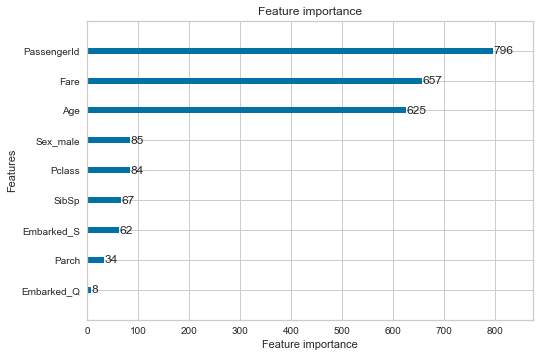

In [59]:
lgb.plot_importance(lgbm_class)
fig.tight_layout()

ImportError: You must install graphviz to plot tree.

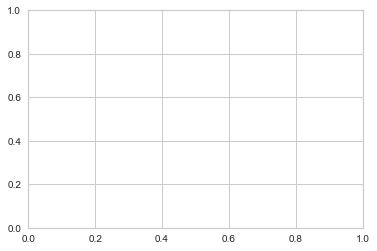

In [61]:
lgb.plot_tree(lgbm_class, tree_index=0)